In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import multiprocessing
from functools import partial
import numpy.random as npr
import matplotlib.dates as mdates
from itertools import product

import sys
import os
core_dir = os.path.join(os.getcwd(), '..', 'daphme')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import garden_city as gcity
from garden_city import Building, Street, City, Agent, Population
import mobility_model as mmod
import stop_detection as sd
from constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS, FAST_STILL_PROBS, SLOW_STILL_PROBS

import pdb

In [2]:
pd.options.mode.chained_assignment = None

Initialization of city and population

In [3]:
city = gcity.load('garden-city.pkl')
population = Population(city)

# Definitions

In [4]:
def identify_stop(alg_out, sparse_traj, stop_table):
    """
    Given the output of a stop detection algorithm, identifies the cluster by 
    the mode location of pings in the cluster.
    """
    merged_df = pd.merge(alg_out, sparse_traj, left_index=True, right_index=True)
    merged_df['location'] = merged_df.apply(lambda ping: city.get_block((ping.x, ping.y)).id, axis=1)
    mode_locations = merged_df.groupby('cluster')['location'].agg(lambda x: x.mode()[0])
    stop_table['location'] = stop_table['cluster_id'].map(mode_locations)
    return stop_table


def q_stat(agent):
    # How to handle partial hours? If last ping is 18:00, count that hour or not?

    sparse_traj = agent.sparse_traj
    traj = agent.trajectory

    if sparse_traj.empty:
        return 0

    sparse_hours = sparse_traj['local_timestamp'].dt.to_period('h')
    full_hours = traj['local_timestamp'].dt.to_period('h')
    num_hours = sparse_hours.nunique()
    total_hours = full_hours.nunique()
    q_stat = num_hours / total_hours
    return q_stat


def radius_of_gyration(df):
    rog = np.sqrt(np.nanmean(np.nansum((df.to_numpy() - np.nanmean(df.to_numpy(), axis=0))**2, axis=1)))
    return rog


def expand_timestamps(df):
    """
    Expands timestamps to individual minutes.
    """
    # Repeat rows based on duration
    repeated_df = df.loc[df.index.repeat(df['duration'])].reset_index(drop=True)

    # Generate the time increments
    repeated_df['minute_increment'] = repeated_df.groupby(['local_timestamp', 'stop_id']).cumcount()
    repeated_df['local_timestamp'] = repeated_df['local_timestamp'] + pd.to_timedelta(repeated_df['minute_increment'], unit='m')
    expanded = repeated_df.drop(columns=['minute_increment', 'duration'])

    expanded['unix_timestamp'] = expanded['local_timestamp'].astype('int64') // 10**9
    expanded = expanded.set_index('unix_timestamp', drop=True)

    return expanded


def prepare_diary(agent):
    """
    Create stop ids, expand to minute level, and filter diary
    to stops that have at least one ping in the sparse trajectory.
    """
    diary = agent.diary.copy()
    diary['x'] = diary['location'].apply(lambda b: city.buildings[b].geometry.centroid.x if b is not None else None)
    diary['y'] = diary['location'].apply(lambda b: city.buildings[b].geometry.centroid.y if b is not None else None)

    sparse_traj = agent.sparse_traj

    # stop_id of trips is -1. Stays are id'ed as 0, 1, 2, ...
    mask = diary['location'].notna()
    diary['stop_id'] = np.where(mask, np.cumsum(mask) - 1, -1)

    # Expand to minute level
    prepared_diary = expand_timestamps(diary)

    # Filter diary to stops that have at least one ping in the sparse trajectory
    # stop_ids = prepared_diary['stop_id']
    # idx = stop_ids.index.intersection(sparse_traj.index)
    # stop_ids = stop_ids.loc[idx]
    # stop_ids = pd.concat([stop_ids, pd.Series([-1], name="stop_id")], ignore_index=True)  # ensure trips are kept
    # keep = stop_ids.unique()
    # prepared_diary = prepared_diary[prepared_diary['stop_id'].isin(keep)]

    return prepared_diary, diary


def prepare_stop_table(stop_table, diary):
    """
    Maps detected stops to diary stops via overlapping location and timeframe,
    and expand to minute level
    """
    keep = stop_table.columns.tolist() + ['stop_id']

    stop_table['end_time'] = stop_table['local_timestamp'] + pd.to_timedelta(stop_table['duration'], unit='m')
    diary['end_time'] = diary['local_timestamp'] + pd.to_timedelta(diary['duration'], unit='m')

    # merge_asof gets stop_table['local_timestamp'] <= diary['end_time'] by location
    joined = pd.merge_asof(
        stop_table,
        diary,
        left_on='local_timestamp',
        right_on='end_time',
        by='location',
        suffixes=('', '_diary'),
        direction='forward'
    )

    # Ensure diary['local_timestamp'] <= stop_table['end_time']
    mask = joined['local_timestamp_diary'] <= joined['end_time']

    # Select the first matching stop_id if multiple matches are found
    joined['stop_id'] = joined.loc[mask, 'stop_id']

    diary.drop(columns=['end_time'], inplace=True)
    stop_table = joined[keep]

    prepared_stop_table = expand_timestamps(stop_table)  # expand to minute level

    return prepared_stop_table, stop_table


def cluster_metrics(stop_table, agent):
    """
    Multiclass classification: compute precision, recall for each class separately,
    then use microaveraging to get the overall precision and recall.
    We could also try duration-weighted macroaveraging.
    """

    # Prepare diary
    prepared_diary, diary = prepare_diary(agent)

    # Prepare stop table
    prepared_stop_table, stop_table = prepare_stop_table(stop_table, diary)

    # Count number of rows in stop_table that match each stop_id in diary
    stop_counts = stop_table['stop_id'].value_counts().reset_index()
    stop_counts.columns = ['stop_id', 'stop_count']

    # Merge on timestamps and locations
    prepared_stop_table.loc[:, 'stop_id'] = prepared_stop_table['stop_id'].fillna(-2)  # -2 refers to stops detected by the sd alg that don't exist in ground truth
    joined = prepared_diary.merge(prepared_stop_table, on=['unix_timestamp', 'stop_id'], how='outer', indicator=True)

    # Compute radius of gyrations
    rog_diary = radius_of_gyration(prepared_diary[['x', 'y']])
    rog_stop_table = radius_of_gyration(prepared_stop_table[['centroid_x', 'centroid_y']])
    rog = {'diary': rog_diary, 'stop_table': rog_stop_table}

    # Duplicated indices denotes conflicting stop labels for the timestamp
    merging_df = joined[joined.index.duplicated(keep=False)]

    # Calculate metrics for each class
    stops = joined['stop_id'].unique()
    stops = stops[stops != -2]
    stops.sort()
    metrics_data = []

    n_stops = len(stops) - 1

    for s in stops:
        s_joined = joined[joined['stop_id'] == s]
        s_tp = s_joined[s_joined['_merge'] == 'both'].shape[0]
        s_fp = s_joined[s_joined['_merge'] == 'right_only'].shape[0]
        s_fn = s_joined[s_joined['_merge'] == 'left_only'].shape[0]

        s_merging = merging_df[(merging_df['_merge'] == 'left_only') & (merging_df['stop_id'] == s)]
        s_m = s_merging.shape[0]
        s_m_stops = merging_df.loc[s_merging.index]
        s_m_stops = s_m_stops[(s_m_stops['_merge'] == 'right_only')]
        s_m_stops = s_m_stops['stop_id'].nunique()

        metrics_data.append({
            'stop_id': s,
            'tp': s_tp,
            'fp': s_fp,
            'fn': s_fn,
            'precision': s_tp / (s_tp + s_fp) if (s_tp + s_fp) != 0 else 0,
            'recall': s_tp / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0,
            'pings_merged': s_m,
            'stops_merged': s_m_stops,
            'prop_merged': s_m / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0
        })

    trips = metrics_data[0]
    metrics_df = pd.DataFrame(metrics_data[1:])
    metrics_df = diary.merge(metrics_df, on=['stop_id'], how='right')
    metrics_df = metrics_df.merge(stop_counts, on=['stop_id'], how='left')
    metrics_df = metrics_df.set_index('stop_id')
    metrics_df['stop_count'] = metrics_df['stop_count'].fillna(0).astype(int)

    tp = metrics_df['tp'].sum()
    fp = metrics_df['fp'].sum()
    fn = metrics_df['fn'].sum()
    stops_merged = metrics_df['stops_merged'].sum()

    # Calculate micro-averaged precision and recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Calculate macro-averaged precision and merging, weighted by duration of stop
    total_duration = metrics_df['duration'].sum()  # total duration = tp + fn
    weighted_precision = (metrics_df['precision'] * metrics_df['duration']).sum() / total_duration
    weighted_merging = (metrics_df['prop_merged'] * metrics_df['duration']).sum() / total_duration

    # Count number of missed and split stops
    num_missed = metrics_df[metrics_df['stop_count'] == 0].shape[0]
    num_split = metrics_df[metrics_df['stop_count'] > 1].shape[0]

    metrics = {
        "Recall": recall,
        "Precision": precision,
        "Weighted Precision": weighted_precision,
        "Missed": num_missed,
        "Stops Merged": stops_merged,
        "Weighted Stop Merging": weighted_merging,
        "Trip Merging": trips['prop_merged'],
        "Split": num_split,
        "Stop Count": n_stops
    }

    return metrics_df, metrics, rog

# Illustration: One User

Initialize agent with ground-truth trajectory and a sparse sampled trajectory.

In [15]:
seed = 377

start_time = [datetime(2024, 6, 1, hour=6, minute=0) + timedelta(minutes=60*t) for t in range(9)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*9
location = ['h-x13-y9'] * 2 + ['h-x13-y8'] * 1 + ['w-x18-y8'] * 1 + ['w-x18-y13'] * 1 + ['p-x13-y11'] * 4

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = gcity.condense_destinations(destination)

Paco = Agent('Paco',
             'h-x13-y9',
             'w-x3-y13',
             city,
             destination_diary=destination)

population.add_agent(Paco)
population.generate_trajectory(Paco, seed=seed, dt=1)

hier_nhpp_params = (89, 45, 6)
Paco.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

Plot sparse sampled trajectory.

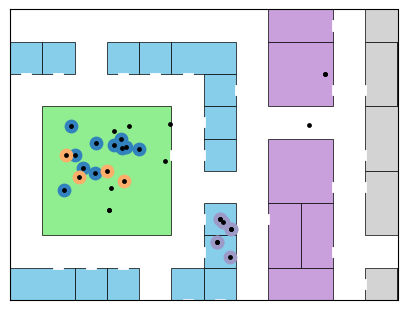

In [17]:
%matplotlib inline

dbscan_params = (60, 1, 2)
dbscan_out = sd.temporal_dbscan(Paco.sparse_traj, *dbscan_params)

lachesis_params = (10, 120, 4)
lachesis_out = sd.lachesis_patches(Paco.sparse_traj, *lachesis_params)

fig, ax = plt.subplots(figsize=(5, 5))

alg2plot = dbscan_out

num_clusters = sum(alg2plot.cluster.unique() > -1)
for cid in range(num_clusters):
    cpings = alg2plot[alg2plot.cluster == cid]
    cdata = Paco.sparse_traj.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

ax.scatter(Paco.sparse_traj.x, Paco.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, zorder=1)

ax.set_xlim(8, 20)
ax.set_ylim(7, 16)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('pathologies.svg')
plt.show()

In [18]:
Paco_stop_table = sd.generate_stop_table(Paco.sparse_traj, dbscan_out)
Paco_stop_table = identify_stop(dbscan_out, Paco.sparse_traj, Paco_stop_table)

Paco_stop_table

,unix_timestamp,local_timestamp,cluster_id,duration,centroid_x,centroid_y,radius,location
0,1717222620,2024-06-01 06:17:00,2,163,14.614586,9.097154,0.427832,h-x13-y9
1,1717239840,2024-06-01 11:04:00,1,46,10.597855,10.998991,0.769557,p-x13-y11
2,1717247880,2024-06-01 13:18:00,0,91,10.807659,11.552608,0.912607,p-x13-y11


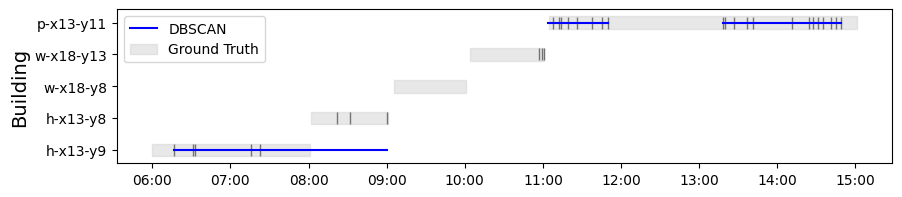

In [29]:
diary = Paco.diary.dropna().copy()
stop_table = Paco_stop_table.copy()
sparse_traj = Paco.sparse_traj.copy()

location_mapping = {loc: idx for idx, loc in enumerate(diary['location'].unique())}
diary['location_num'] = diary['location'].map(location_mapping)
stop_table['location_num'] = stop_table['location'].map(location_mapping)

# Create the plot
plt.figure(figsize=(10, 2))

# Plot stop_table
for idx, row in stop_table.iterrows():
    start_time = row['local_timestamp']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.plot([start_time, end_time], [row['location_num'], row['location_num']], color='blue', label='DBSCAN' if idx == 0 else "", zorder=3)

# Plot diary data with shaded rectangles
for idx, row in diary.iterrows():
    start_time = row['local_timestamp']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.fill_between([start_time, end_time], [row['location_num'] - 0.2, row['location_num'] - 0.2], [row['location_num'] + 0.2, row['location_num'] + 0.2], color='lightgrey', alpha=0.5, label='Ground Truth' if idx == 0 else "", zorder=1)
    pings = sparse_traj[(sparse_traj['local_timestamp'] >= start_time) & (sparse_traj['local_timestamp'] <= end_time)]
    pings = pings['local_timestamp'].to_frame()
    pings['location_num'] = row['location_num']
    plt.plot(pings['local_timestamp'], pings['location_num'], '|', markersize=8, color='black', alpha=0.5, zorder=2)

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=1))
#plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Building', fontsize=14)
plt.yticks(ticks=list(location_mapping.values()), labels=list(location_mapping.keys()))
plt.legend()

plt.savefig('stops_temporal.svg')
plt.show()

## Diary vs stops, population average

### Generate N agents

In [13]:
# %%time

# population_n = Population(city)
# population_n.generate_agents(200, seed=716)

# def generate_agent_trajectory(agent_id, shared_roster, seed):
#     agent = shared_roster[agent_id]
#     population_n.generate_trajectory(agent, T=datetime(2024, 1, 15, hour=8, minute=0), seed=seed)
#     shared_roster[agent_id] = agent

# manager = multiprocessing.Manager()
# shared_roster = manager.dict(population_n.roster)

# with ProcessPoolExecutor() as executor:
#     futures = [
#         executor.submit(generate_agent_trajectory, agent_id, shared_roster, i)
#         for i, agent_id in enumerate(shared_roster)
#     ]
#     concurrent.futures.wait(futures)

# population_n.roster = dict(shared_roster)

# population_n.save_pop('trajectories-100/')

CPU times: user 39 s, sys: 2.19 s, total: 41.2 s
Wall time: 5min 38s


In [ ]:
# %%time

# # Load csvs

# population_n = Population(city)
# population_n.load_pop('trajectories-100/', parallelize=True)

In [14]:
# custom version to generate the next plot

def sample_hier_nhpp(traj, beta_start, beta_durations, beta_ping, seed=0):
    npr.seed(seed)

    # Sample starting points of bursts
    inter_arrival_times = npr.exponential(scale=beta_start, size=len(traj))
    burst_start_points = np.cumsum(inter_arrival_times).astype(int)
    burst_start_points = burst_start_points[burst_start_points < len(traj)]

    # Sample durations of each burst
    burst_durations = np.random.exponential(scale=beta_durations, size=len(burst_start_points)).astype(int)

    # Create start_points and end_points
    burst_end_points = burst_start_points + burst_durations
    burst_end_points = np.minimum(burst_end_points, len(traj) - 1)

    # Adjust end_points to handle overlaps
    for i in range(len(burst_start_points) - 1):
        if burst_end_points[i] > burst_start_points[i + 1]:
            burst_end_points[i] = burst_start_points[i + 1]

    burst_info = pd.DataFrame(columns=['start_time', 'end_time'])

    # Sample pings within each burst
    sampled_trajectories = []
    burst_info = []
    for start, end in zip(burst_start_points, burst_end_points):
        start_time = traj.iloc[start]['local_timestamp']
        end_time = traj.iloc[end]['local_timestamp']
        entry = {'start_time': start_time,
                 'end_time': end_time}
        burst_info.append(entry)

        burst_indices = np.arange(start, end)

        if len(burst_indices) == 0:
            continue

        ping_intervals = np.random.exponential(scale=beta_ping, size=len(burst_indices))
        ping_times = np.unique(np.cumsum(ping_intervals).astype(int))
        ping_times = ping_times[ping_times < (end - start)] + start

        if len(ping_times) == 0:
            continue

        burst_data = traj.iloc[ping_times].copy()
        burst_data['first_ping'] = 0
        if not burst_data.empty:
            burst_data.iloc[0, burst_data.columns.get_loc('first_ping')] = 1

        sampled_trajectories.append(burst_data)

    if sampled_trajectories:
        sampled_traj = pd.concat(sampled_trajectories).sort_values(by='unix_timestamp')
    else:  # empty
        sampled_traj = pd.DataFrame(columns=list(traj.columns))

    burst_info = pd.DataFrame(burst_info)

    sampled_traj = sampled_traj.drop_duplicates('local_timestamp')

    return sampled_traj, burst_info

In [372]:
# beta_starts = range(120, 1600, 40)
# beta_durs = range(30, 400, 10)
# beta_ping = 10

#nhpp_params = [(240, 60, 5), (1600, 180, 30)]
nhpp_params = [(240, 60, 10), (1600, 400, 10)]
seed = 250

0.26706231454005935


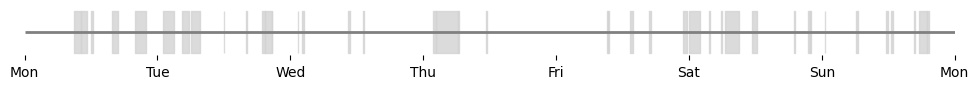

In [375]:
agent = population_n.roster['sad_wozniak']

param = nhpp_params[0]
agent.sparse_traj, burst_info = sample_hier_nhpp(agent.trajectory, *param, seed=seed)
print(q_stat(agent))

fig, ax = plt.subplots(figsize=(12, 0.6))

ax.hlines(1, pd.Timestamp('2024-01-01 00:00'), pd.Timestamp('2024-01-08 00:00'), color='gray', linewidth=2)

# ax.vlines(burst_info['start_time'], 0.95, 1.05, color='red', linewidth=1.2, alpha=1)

for i, row in burst_info.iterrows():
    ax.fill_betweenx(
        [0.95, 1.05], 
        row['start_time'], 
        row['end_time'], 
        color='lightgrey', 
        alpha=0.8, 
        zorder=1
    )

#ax.vlines(agent.sparse_traj['local_timestamp'], 0.95, 1.05, color='black', linewidth=0.3, alpha=1)

ax.set_xlim(pd.Timestamp('2024-01-01 00:00'), pd.Timestamp('2024-01-08 00:00'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.xticks(rotation=0)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.yaxis.set_visible(False)

plt.show()

0.2818991097922849


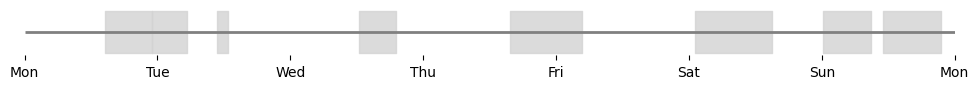

In [376]:
agent = population_n.roster['sad_wozniak']

param = nhpp_params[1]
agent.sparse_traj, burst_info = sample_hier_nhpp(agent.trajectory, *param, seed=seed)
print(q_stat(agent))

fig, ax = plt.subplots(figsize=(12, 0.6))

ax.hlines(1, pd.Timestamp('2024-01-01 00:00'), pd.Timestamp('2024-01-08 00:00'), color='gray', linewidth=2)

#ax.vlines(burst_info['start_time'], 0.95, 1.05, color='red', linewidth=1.2, alpha=1)

for i, row in burst_info.iterrows():
    ax.fill_betweenx(
        [0.95, 1.05], 
        row['start_time'], 
        row['end_time'], 
        color='lightgrey', 
        alpha=0.8, 
        zorder=1
    )

#ax.vlines(agent.sparse_traj['local_timestamp'], 0.95, 1.05, color='black', linewidth=0.3, alpha=1)

ax.set_xlim(pd.Timestamp('2024-01-01 00:00'), pd.Timestamp('2024-01-08 00:00'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.xticks(rotation=0)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.yaxis.set_visible(False)

plt.show()

In [308]:
%%time

# hier_nhpp_params = [(240, 60, 5), (1600, 180, 30)]
# dbscan_params = [(180, 5, 2), (30, 1.5, 3)]

hier_nhpp_params = [(180, 180, 10), (1200, 120, 30)]
dbscan_params = [(180, 7, 2), (45, 2, 3)]

def generate_stop_table(agent_id, population, seed, hier_nhpp_params, dbscan_params):
    agent = population.roster[agent_id]
    combined = []
    for i, hier_nhpp_param in enumerate(hier_nhpp_params):
        agent.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)
        for j, dbscan_param in enumerate(dbscan_params):
            dbscan_out = sd.temporal_dbscan(agent.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(agent.sparse_traj, dbscan_out)
            if stop_table.empty:
                continue
            stop_table = identify_stop(dbscan_out, agent.sparse_traj, stop_table)
            _, _, rog = cluster_metrics(stop_table, agent)
            stop_table['id'] = agent_id
            stop_table['dbscan'] = ['coarse', 'fine'][j]
            stop_table['sparsity'] = ['low', 'high'][i]
            stop_table['rog_d'] = rog['diary']
            stop_table['rog_sd'] = rog['stop_table']
            combined.append(stop_table)

    combined = pd.concat(combined, ignore_index=True)
    return combined

#agent_ids = list(population.roster.keys())
agent_ids = {k: population_n.roster[k] for k in list(population_n.roster)[:45]}
seeds = range(len(agent_ids))

generate_stop_table_partial = partial(
    generate_stop_table,
    population=population_n,
    hier_nhpp_params=hier_nhpp_params,
    dbscan_params=dbscan_params
)

params = [(agent_id, seed+200) for agent_id, seed in zip(agent_ids, seeds)]

def generate_stop_table_wrapper(agent_id, seed):
    return generate_stop_table_partial(agent_id=agent_id, seed=seed)

with ProcessPoolExecutor() as executor:
    all_stop_tables = list(executor.map(generate_stop_table_wrapper, agent_ids, seeds, chunksize=1))

all_stop_tables = pd.concat(all_stop_tables, ignore_index=True)

CPU times: user 98.3 ms, sys: 2.2 s, total: 2.3 s
Wall time: 20.2 s


## Bar charts from diaries, type vs fraction_time

In [389]:
output_type = []
output_size = []
output_truehome = []
for agent_id, agent in population_n.roster.items():
    d = agent.diary.dropna()
    d['id'] = agent_id
    d['type'] = d['location'].apply(lambda b: city.buildings[b].building_type)
    d['size'] = d['location'].apply(lambda b: len(city.buildings[b].blocks) if b in city.buildings else None)
    d['true_home'] = d.apply(lambda x: agent.home == x.location, axis=1)
    bin_edges = [0, 1, 4, 100]
    bin_labels = ['small', 'medium', 'large']
    d['size'] = pd.cut(d['size'], bins=bin_edges, labels=bin_labels, include_lowest=True)

    d_type_agg = d.groupby(['id', 'type'], observed=False).duration.sum().reset_index()
    d_size_agg = d.groupby(['id', 'size'], observed=False).duration.sum().reset_index()
    d_truehome_agg = d.groupby(['id', 'true_home'], observed=False).duration.sum().reset_index()
    output_type += [d_type_agg]
    output_size += [d_size_agg]
    output_truehome += [d_truehome_agg]

bars_type_gc = pd.concat(output_type)
temp = bars_type_gc.groupby('id')['duration'].transform('sum')
bars_type_gc['duration'] = bars_type_gc['duration'] / temp

bars_size_gc = pd.concat(output_size)
temp = bars_size_gc.groupby('id')['duration'].transform('sum')
bars_size_gc['duration'] = bars_size_gc['duration'] / temp

bars_trhome_gc = pd.concat(output_truehome)
temp = bars_trhome_gc.groupby('id')['duration'].transform('sum')
bars_trhome_gc['duration'] = bars_trhome_gc['duration'] / temp

all_stop_tables['type'] = all_stop_tables['location'].apply(
    lambda b: city.buildings[b].building_type if b in city.buildings else None)

all_stop_tables['true_home'] = all_stop_tables.apply(
    lambda x: population_n.roster[x.id].home == x.location, axis=1)

all_stop_tables['size'] = all_stop_tables['location'].apply(
    lambda b: len(city.buildings[b].blocks) if b in city.buildings else None)
bin_edges = [0, 1, 4, 100]
bin_labels = ['small', 'medium', 'large']
all_stop_tables['size'] = pd.cut(all_stop_tables['size'], bins=bin_edges, labels=bin_labels, include_lowest=True)

bars_type = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'type'], observed=False).duration.sum().reset_index()
temp = bars_type.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_type['duration'] = bars_type['duration'] / temp

bars_size = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'size'], observed=False).duration.sum().reset_index()
temp = bars_size.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_size['duration'] = bars_size['duration'] / temp

bars_trhome = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'true_home'], observed=False).duration.sum().reset_index()
temp = bars_trhome.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_trhome['duration'] = bars_trhome['duration'] / temp

# Ensure all combinations of 'id', 'dbscan', 'sparsity', and 'type' are present
unique_ids = bars_type['id'].unique()
unique_dbscan = bars_type['dbscan'].unique()
unique_sparsity = bars_type['sparsity'].unique()
unique_types = bars_type['type'].unique()
all_combinations = pd.DataFrame(list(product(unique_ids, unique_dbscan, unique_sparsity, unique_types)),
                                columns=['id', 'dbscan', 'sparsity', 'type'])
bars_type = all_combinations.merge(bars_type, on=['id', 'dbscan', 'sparsity', 'type'], how='left')
bars_type['duration'] = bars_type['duration'].fillna(0)

bars_rog = all_stop_tables.groupby(['id', 'dbscan', 'sparsity']).agg(
    rog_d=('rog_d', 'mean'),
    rog_sd=('rog_sd', 'mean')
).reset_index()

[Text(0.2, 0, 'Low Sparsity'), Text(1.2, 0, 'High Sparsity')]

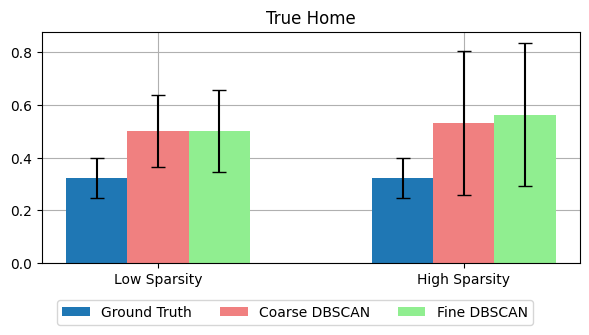

In [310]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
bar_width = 0.2
index = np.arange(len(sparsity_levels))

grouped_gc = bars_trhome_gc.groupby('true_home')['duration']
mean_duration_gc = grouped_gc.mean()[True]
std_duration_gc = grouped_gc.std()[True]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

ax.bar(index, mean_duration_gc, bar_width, yerr=std_duration_gc, capsize=5, label='Ground Truth', color=colors[0])

for j, dbscan_param in enumerate(dbscan_options):
    df_sparsity = bars_trhome[bars_trhome['dbscan'] == dbscan_param]

    mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
    std_duration = df_sparsity.groupby('sparsity')['duration'].std()

    mean_duration = mean_duration.sort_index(ascending=False)
    std_duration = std_duration.sort_index(ascending=False)

    bar_positions = index + (j + 1) * bar_width
    ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
           capsize=5, label=labels[j + 1], color=colors[j + 1])
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

ax.set_title('True Home')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labelsx, rotation=0)

[Text(0.2, 0, 'Low Sparsity'), Text(1.2, 0, 'High Sparsity')]

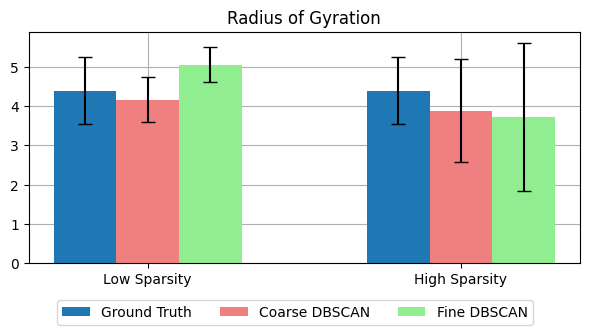

In [311]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
bar_width = 0.2
index = np.arange(len(sparsity_levels))

mean_gc = bars_rog['rog_d'].mean()
std_gc = bars_rog['rog_d'].std()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

for j, dbscan_param in enumerate(dbscan_options):
    df_sparsity = bars_rog[bars_rog['dbscan'] == dbscan_param]

    mean_duration = df_sparsity.groupby('sparsity')['rog_sd'].mean()
    std_duration = df_sparsity.groupby('sparsity')['rog_sd'].std()

    mean_duration = mean_duration.sort_index(ascending=False)
    std_duration = std_duration.sort_index(ascending=False)

    bar_positions = index + (j + 1) * bar_width
    ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
           capsize=5, label=labels[j + 1], color=colors[j + 1])
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

ax.set_title('Radius of Gyration')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labelsx, rotation=0)

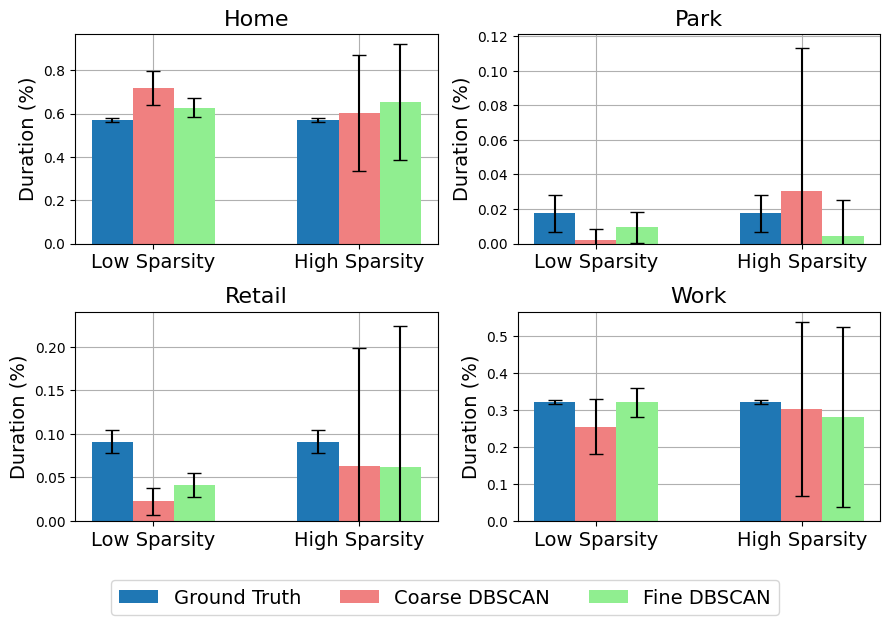

In [393]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
building_types = bars_type_gc['type'].unique()

grouped_gc = bars_type_gc.groupby('type')['duration']
mean_duration_gc = grouped_gc.mean()
std_duration_gc = grouped_gc.std()

bar_width = 0.2
index = np.arange(len(sparsity_levels))

fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

for k, building_type in enumerate(building_types):
    ax = axes[k]

    mean_gc = mean_duration_gc[building_type]
    std_gc = std_duration_gc[building_type]
    ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

    for j, dbscan_param in enumerate(dbscan_options):
        df_sparsity = bars_type[bars_type['dbscan'] == dbscan_param]
        df_sparsity = df_sparsity[df_sparsity['type'] == building_type]

        mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
        std_duration = df_sparsity.groupby('sparsity')['duration'].std()

        mean_duration = mean_duration.sort_index(ascending=False)
        std_duration = std_duration.sort_index(ascending=False)

        bar_positions = index + (j + 1) * bar_width
        ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
               capsize=5, label=labels[j + 1], color=colors[j + 1])

    ax.set_title(f'{building_type.capitalize()}', fontsize=16)
    ax.set_ylabel('Duration (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labelsx, rotation=0, fontsize=14)
    ax.set_ylim(0,)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=14)

plt.savefig('bar_charts.svg')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

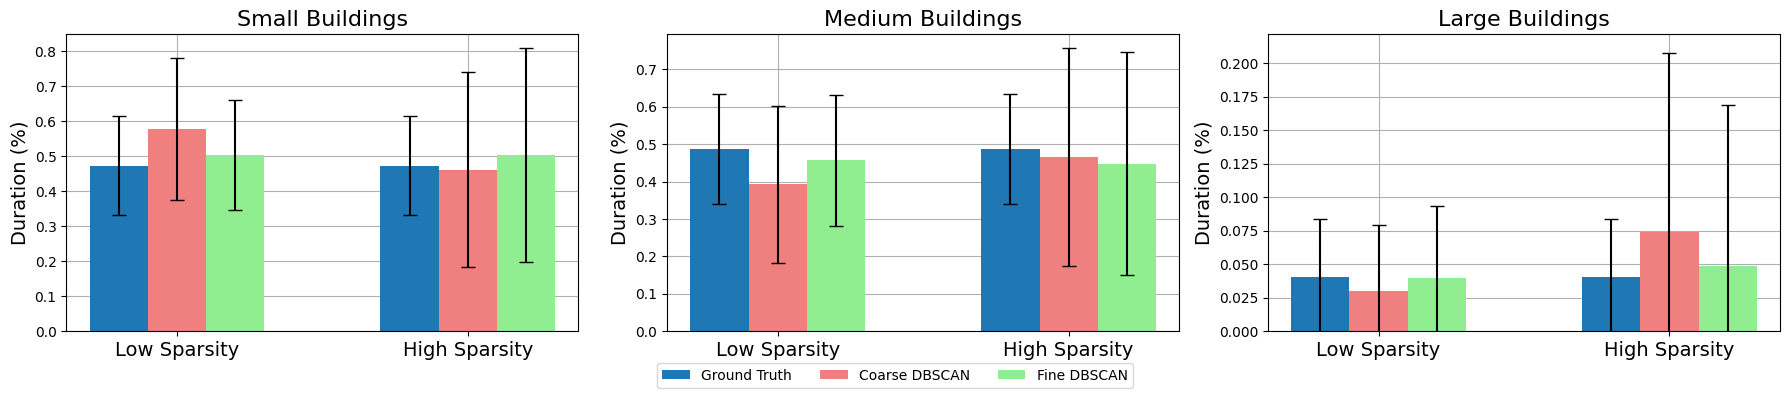

In [313]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
building_sizes = bars_size_gc['size'].unique()

grouped_gc = bars_size_gc.groupby('size', observed=False)['duration']
mean_duration_gc = grouped_gc.mean()
std_duration_gc = grouped_gc.std()

bar_width = 0.2
index = np.arange(len(sparsity_levels))

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes = axes.flatten()

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

for k, building_size in enumerate(building_sizes):
    ax = axes[k]

    mean_gc = mean_duration_gc[building_size]
    std_gc = std_duration_gc[building_size]
    ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

    for j, dbscan_param in enumerate(dbscan_options):
        df_sparsity = bars_size[bars_size['dbscan'] == dbscan_param]
        df_sparsity = df_sparsity[df_sparsity['size'] == building_size]

        mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
        std_duration = df_sparsity.groupby('sparsity')['duration'].std()

        mean_duration = mean_duration.sort_index(ascending=False)
        std_duration = std_duration.sort_index(ascending=False)

        bar_positions = index + (j + 1) * bar_width
        ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
               capsize=5, label=labels[j + 1], color=colors[j + 1])

    ax.set_title(f'{building_size.capitalize()} Buildings', fontsize=16)
    ax.set_ylabel('Duration (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labelsx, rotation=0, fontsize=14)
    ax.set_ylim(0,)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.savefig('bar_size.svg')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Curves

### Fix frequency (q). Vary sparsity pattern by changing first two params.

In [13]:
%%time

def process_seed(seed, nhpp_params, dbscan_params, lachesis_params, city):
    results_dbscan = []
    results_lachesis = []
    
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    start_time=datetime(2024, 1, 1, hour=0, minute=0))

    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, T=datetime(2024, 1, 15, hour=0, minute=0), seed=seed)

    for nhpp_param in nhpp_params: 
        Bethany.sample_traj_hier_nhpp(*nhpp_param, seed=seed)
        qstat = q_stat(Bethany)

        for k in range(len(dbscan_params)):
            dbscan_param = dbscan_params[k]
            lachesis_param = lachesis_params[k]

            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            lachesis_out = sd.lachesis_patches(Bethany.sparse_traj, *lachesis_param)

            stop_table_dbscan = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)
            stop_table_lachesis = sd.generate_stop_table(Bethany.sparse_traj, lachesis_out)

            result_dbscan = {
                'seed': seed,
                'alg_param': ['coarse', 'fine'][k],
                'beta_dur': nhpp_param[1],
                'q': qstat,
                'recall': 0,
                'precision': 0,
                'stop_merging': None,
                'trip_merging': None,
                'missed': 0,
                'split': None,
                'rog_diary': 0,
                'rog_alg': 0
            }

            result_lachesis = result_dbscan.copy()

            if stop_table_dbscan.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_dbscan.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_dbscan = identify_stop(dbscan_out, Bethany.sparse_traj, stop_table_dbscan)
                # stop_table_dbscan['location'] = stop_table_dbscan.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_dbscan, Bethany)
                result_dbscan.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged'],#/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed'],#/metrics['Stop Count'],
                    'split': metrics['Split'],#/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

            if stop_table_lachesis.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_lachesis.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_lachesis = identify_stop(lachesis_out, Bethany.sparse_traj, stop_table_lachesis)
                # stop_table_lachesis['location'] = stop_table_lachesis.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_lachesis, Bethany)
                result_lachesis.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged'],#/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed'],#/metrics['Stop Count'],
                    'split': metrics['Split'],#/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

                results_dbscan.append(result_dbscan)
                results_lachesis.append(result_lachesis)

    return pd.DataFrame(results_dbscan), pd.DataFrame(results_lachesis)


seeds = range(1, 175)
dbscan_params = [(360, 5, 2), (60, 1.5, 3)]
lachesis_params = [(10, 480, 6), (10, 60, 1.5)]
beta_starts = range(120, 1600, 40)
beta_durs = range(30, 400, 10)
beta_ping = 10

nhpp_params = [(start, dur, beta_ping) for start, dur in zip(beta_starts, beta_durs)]

with ProcessPoolExecutor() as executor:
    work = partial(process_seed, nhpp_params=nhpp_params,
                   dbscan_params=dbscan_params, lachesis_params=lachesis_params,
                   city=city)
    all_results = list(executor.map(work, seeds))

results_dbscan = [result[0] for result in all_results]
results_lachesis = [result[1] for result in all_results]

results_dbscan = pd.concat(results_dbscan, ignore_index=True)
results_lachesis = pd.concat(results_lachesis, ignore_index=True)

results_dbscan.to_pickle('results-sparsity-dbscan-nofilter-1.pkl')
results_lachesis.to_pickle('results-sparsity-lachesis-nofilter-1.pkl')

CPU times: user 14.3 s, sys: 1.56 s, total: 15.8 s
Wall time: 20min 34s


In [40]:
import pickle

with open('results-sparsity-dbscan-nofilter.pkl', 'rb') as file:
    results_dbscan = pickle.load(file)

with open('results-sparsity-lachesis-nofilter.pkl', 'rb') as file:
    results_lachesis = pickle.load(file)

In [41]:
# Create bins for q, size 0.05 from 0 to 1
# bins = np.arange(0, 1.05, 0.05)
# labels = [i/100+0.025 for i in range(0, 100, 5)]
# results_dbscan['q_bin'] = pd.cut(results_dbscan['q'], bins=bins, labels=labels, include_lowest=True)
# results_lachesis['q_bin'] = pd.cut(results_lachesis['q'], bins=bins, labels=labels, include_lowest=True)

results_dbscan_sparsity = results_dbscan.groupby(['beta_dur', 'alg_param'], observed=True).mean().reset_index()
counts = results_dbscan.groupby(['beta_dur', 'alg_param'], observed=True).size().reset_index(name='count')
results_dbscan_sparsity = results_dbscan_sparsity.merge(counts, on=['beta_dur', 'alg_param'])
results_dbscan_sparsity = results_dbscan_sparsity[results_dbscan_sparsity['count'] >= 10]

results_lachesis_sparsity = results_lachesis.groupby(['beta_dur', 'alg_param'], observed=True).mean().reset_index()
counts = results_lachesis.groupby(['beta_dur', 'alg_param'], observed=True).size().reset_index(name='count')
results_lachesis_sparsity = results_lachesis_sparsity.merge(counts, on=['beta_dur', 'alg_param'])
results_lachesis_sparsity = results_lachesis_sparsity[results_lachesis_sparsity['count'] >= 10]

In [42]:
results_dbscan_sparsity
#results_lachesis_sparsity

,beta_dur,alg_param,seed,q,recall,precision,stop_merging,trip_merging,missed,split,rog_diary,rog_alg,count
0,30,coarse,87.5,0.373597,0.328536,0.707689,0.251049,0.228805,0.795209,0.004219,5.672063,4.900081,174
1,30,fine,87.5,0.373597,0.105759,0.978292,0.009175,0.006257,0.815534,0.038291,5.672063,5.266259,174
2,40,coarse,87.5,0.375559,0.321468,0.710486,0.247324,0.225396,0.792344,0.004620,5.672063,4.935803,174
3,40,fine,87.5,0.375559,0.126098,0.974532,0.010819,0.006348,0.801968,0.041997,5.672063,5.244220,174
4,50,coarse,87.5,0.377810,0.314813,0.714882,0.240376,0.219294,0.789148,0.005973,5.672063,4.931838,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,370,fine,87.5,0.343105,0.239353,0.949467,0.026364,0.019491,0.799452,0.014307,5.672063,5.333524,174
70,380,coarse,87.5,0.341963,0.230012,0.739837,0.177476,0.165287,0.830397,0.001771,5.672063,5.078542,174
71,380,fine,87.5,0.341963,0.239249,0.949809,0.025890,0.019679,0.799101,0.012288,5.672063,5.361036,174
72,390,coarse,87.5,0.341178,0.229814,0.740757,0.176183,0.164188,0.833970,0.001479,5.672063,5.092245,174


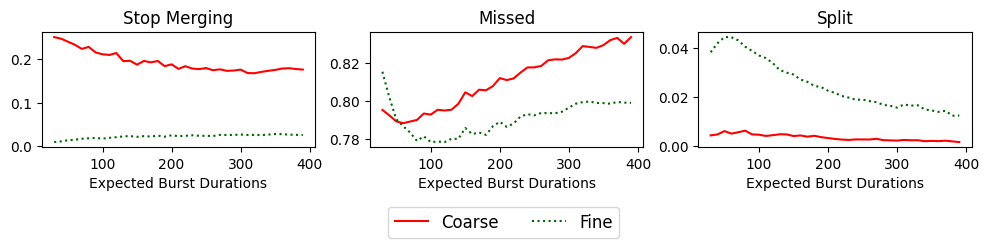

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(12, 1.5))

for i, p in enumerate([2,4,5]):
    ax = axes[i]
    for j in range(2):
        setting = ['coarse', 'fine'][j]
        results_df = results_dbscan_sparsity[results_dbscan_sparsity['alg_param']==setting]
        ax.plot(results_df['beta_dur'], results_df.iloc[:, p+4],
                label=['Coarse', 'Fine'][j],
                color=['red', 'darkgreen'][j],
                linestyle=['-', ':'][j])
        ax.set_title(['Stop Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')
        ax.set_xlabel('Expected Burst Durations')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.55))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

plt.savefig("metrics_vs_sparsity-dbscan.png")
plt.show()

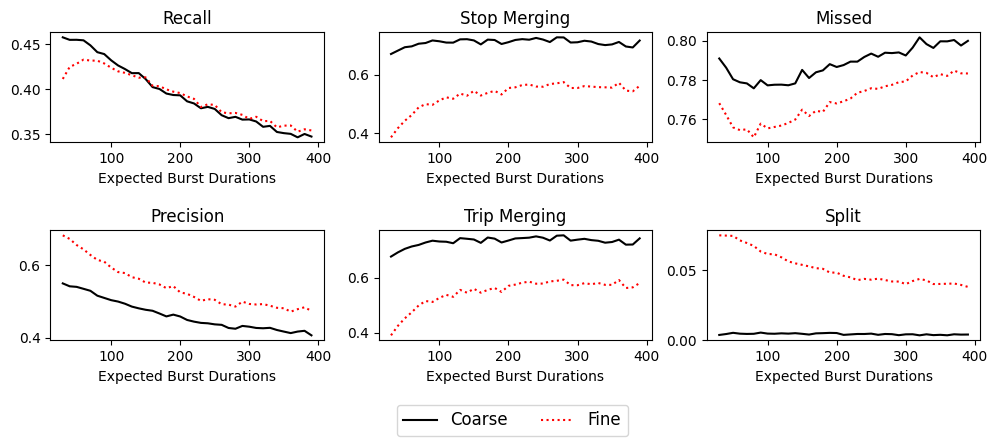

In [349]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i in range(6):
    ax = axes[i % 2, i//2]
    for j in range(2):
        setting = ['coarse', 'fine'][j]
        results_df = results_lachesis_sparsity[results_lachesis_sparsity['alg_param']==setting]
        ax.plot(results_df['beta_dur'], results_df.iloc[:, i+4],
                label=['Coarse', 'Fine'][j],
                color=['black', 'red'][j],
                linestyle=['-', ':'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')
        ax.set_xlabel('Expected Burst Durations')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.15))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

plt.savefig("metrics_vs_sparsity-lachesis.png")
plt.show()

### Fix sparsity. Vary DBSCAN parameters.

In [ ]:
seeds = range(100, 150)
hier_nhpp_params = [(90, 30, 4), (60, 60, 2)]  # 3pph, 12pph

# dbscan_params = (time_thresh, dist_thresh, min_pts)
dist_threshs = np.arange(5/15, 200/15, 0.25)

results = np.zeros((len(seeds), len(hier_nhpp_params), len(dist_threshs), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, hier_nhpp_param in enumerate(hier_nhpp_params):
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)
        truepph = round(len(Bethany.sparse_traj) * 2 / 9) / 2
        print(truepph)

        for k, dist_thresh in enumerate(dist_threshs):
            dbscan_param = (240, dist_thresh, 2)
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = dist_thresh
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Trip Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = q_stat(Bethany)  # q
                continue

            stop_table['location'] = stop_table.apply(
                lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = dist_thresh
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            #results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 3] = metrics['Stops Merged']
            results[i, j, k, 4] = metrics['Trip Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_param = np.nanmean(results, axis=0)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_param[j, :, :],
            columns=['dist_thresh', 'recall', 'precision', 'weighted_stop_merging', 'trip_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['dist_thresh'], results_df.iloc[:, i+1],
                label=['3pph', '12pph'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. DBSCAN parameters', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_params.png")
plt.show()